# machine.ipynb

This notebook contains **machine learning analysis** to predict student stress levels from their daily lifestyle factors. The main notebook (`main.ipynb`) reports a summary with two key figures.

<br>

## Research Question

Can we predict a student's stress level (Low, Moderate, or High) from lifestyle factors like study hours, sleep hours, social time, and physical activity?

<br>

## Approach

### Data
- **Target variable (y)**: Stress level (Low=1, Moderate=2, High=3)
- **Features (X)**: Study hours, sleep hours, social hours, activity hours, Gender
- **Validation**: 5-fold cross-validation (each student is in the test set exactly once)

### Models
1. **K-Nearest Neighbors (KNN)** — classifies based on the most common class among similar students
2. **Decision Tree** — learns simple rules to separate stress categories

### Preprocessing
- **StandardScaler**: Normalizes features to mean=0, std=1 (important for KNN's distance calculations)
- **PCA**: Tests whether reducing dimensions improves performance

### Analysis Goals
- Find optimal hyperparameters using cross-validation
- Identify which lifestyle factors are most important for predicting stress
- Compare model performance and understand why one might work better

---

## Setup and Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
%%capture
%run 'parse_data.ipynb'

In [3]:
X = df[['studyhours', 'sleephours', 'socialhours', 'activityhours', 'Gender']]
y = df['stress']

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Check stress distribution
print("\nStress Level Distribution:")
print(y.value_counts().sort_index())
print("\nPercentages:")
print((y.value_counts(normalize=True).sort_index() * 100).round(1))
print(f"\nTotal dataset size: {len(df)} students")


Stress Level Distribution:
stress
1     297
2     674
3    1029
Name: count, dtype: int64

Percentages:
stress
1    14.8
2    33.7
3    51.4
Name: proportion, dtype: float64

Total dataset size: 2000 students


**Stress Level Distribution:**

The dataset contains 2000 students with the following stress distribution:
- Low stress (1): ~15% of students
- Moderate stress (2): ~34% of students
- High stress (3): ~51% of students

The classes are somewhat imbalanced (High stress is most common), but not severely so. This is actually realistic — student populations often have more stressed than relaxed individuals.

---

## Preprocessing:  Scaling

KNN uses Euclidean distance to find nearest neighbors. Without scaling, features with larger ranges dominate the distance calculation.

Our features have different ranges:
- studyhours: 5-10
- sleephours:  5-10
- socialhours: 0-6
- activityhours: 0-13
- Gender: 0-1

StandardScaler transforms each feature to mean=0 and std=1, so all features contribute equally.

<br>

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

After scaling, all features have mean ≈ 0 and std = 1.

---

## Dimensionality Reduction:  PCA

PCA finds directions of maximum variance in the data. If features are correlated, fewer components can explain most of the variance.

From our classical analysis, we know study hours is the dominant factor in student outcomes. PCA should help confirm which features contain the most information.

<br>

In [5]:
pca_full = PCA(n_components=5)
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Create variance table
pca_variance_table = pd.DataFrame({
    'Components': [f'{i} component(s)' for i in range(1, 6)],
    'Cumulative Variance': [f'{var*100:.0f}%' for var in cumulative_variance]
})
print("Table 3: PCA Cumulative Variance Explained")
display(pca_variance_table)

Table 3: PCA Cumulative Variance Explained


,Components,Cumulative Variance
0,1 component(s),34%
1,2 component(s),59%
2,3 component(s),79%
3,4 component(s),98%
4,5 component(s),100%


**PCA Results:**

Cumulative variance explained by principal components:
- PC1 alone: 34%
- PC1-2: 59%
- PC1-3: 79%
- PC1-4: 98%
- PC1-5: 100%

We need 4 components to capture 98% of variance. This tells us that the features in this dataset are **not highly correlated** — if they were, fewer components would explain most of the variance. We'll test both scaled data and PCA-reduced data to see which performs better.

---

In [6]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

---

## Parameter Tuning with Cross-Validation

Using 5-fold cross-validation to test different hyperparameters and find optimal settings. For KNN, testing with scaled data.

<br>

In [7]:
# KNN tuning with scaled features
knn_results = []
for k in [3, 5, 7, 9, 11, 15]:
    scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_scaled, y, cv=kfold)
    knn_results.append({'n_neighbors': k, 'mean': scores.mean(), 'std': scores.std()})

knn_df = pd.DataFrame(knn_results)
best_knn_k = knn_df.loc[knn_df['mean'].idxmax(), 'n_neighbors']
print("Table 4: KNN Hyperparameter Tuning Results")
display(knn_df[['n_neighbors', 'mean']].rename(columns={'mean': 'Mean Accuracy'}).style.format({'Mean Accuracy': '{:.2%}'}))

Table 4: KNN Hyperparameter Tuning Results


,n_neighbors,Mean Accuracy
0,3,91.90%
1,5,92.05%
2,7,92.25%
3,9,92.25%
4,11,92.90%
5,15,92.50%


In [8]:
# Decision Tree tuning (doesn't need scaling)
tree_results = []
for depth in [3, 4, 5, 6]:
    scores = cross_val_score(DecisionTreeClassifier(max_depth=depth, random_state=42), X, y, cv=kfold)
    tree_results.append({'max_depth': depth, 'mean': scores.mean(), 'std': scores.std()})

tree_df = pd.DataFrame(tree_results)
best_tree_depth = int(tree_df.loc[tree_df['mean'].idxmax(), 'max_depth'])
print("Table 5: Decision Tree Hyperparameter Tuning Results")
display(tree_df[['max_depth', 'mean']].rename(columns={'mean': 'Mean Accuracy'}).style.format({'Mean Accuracy': '{:.2%}'}))

Table 5: Decision Tree Hyperparameter Tuning Results


,max_depth,Mean Accuracy
0,3,100.00%
1,4,100.00%
2,5,100.00%
3,6,100.00%


Best KNN:  n_neighbors=11.  Best Decision Tree: max_depth=3 (simplest with 100% accuracy).

---

## Model Comparison:  Effect of Preprocessing

Comparing KNN performance on raw vs preprocessed data.

<br>

In [9]:
knn_raw = cross_val_score(KNeighborsClassifier(n_neighbors=11), X, y, cv=kfold)
knn_scaled = cross_val_score(KNeighborsClassifier(n_neighbors=11), X_scaled, y, cv=kfold)
knn_pca = cross_val_score(KNeighborsClassifier(n_neighbors=11), X_pca, y, cv=kfold)

comparison = pd.DataFrame({
    'Data': ['Raw', 'Scaled', 'PCA (4 comp)'],
    'Mean Accuracy': [f"{s.mean()*100:.2f}%" for s in [knn_raw, knn_scaled, knn_pca]],
    'Std': [f"±{s.std()*100:.2f}%" for s in [knn_raw, knn_scaled, knn_pca]]
})
print("Table 6: Effect of Preprocessing on KNN Performance")
display(comparison)

Table 6: Effect of Preprocessing on KNN Performance


,Data,Mean Accuracy,Std
0,Raw,91.80%,±1.45%
1,Scaled,92.90%,±0.64%
2,PCA (4 comp),89.95%,±1.25%


**Preprocessing Effect on KNN**

**Key Findings:**
- **Scaling helps:** Improves accuracy by ~1.1% and reduces variance significantly
- **PCA hurts:** Reducing to 4 components actually decreases accuracy

Why does PCA hurt? Because each feature contains unique predictive information. While the Decision Tree (as we'll see) only uses 2 features, KNN benefits from having all 5 features available. PCA's linear combinations lose information that KNN needs.

---

## Feature Importance (Decision Tree)

In [10]:
tree_model = DecisionTreeClassifier(max_depth=best_tree_depth, random_state=42)
tree_model.fit(X, y)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tree_model. feature_importances_
}).sort_values('Importance', ascending=False)

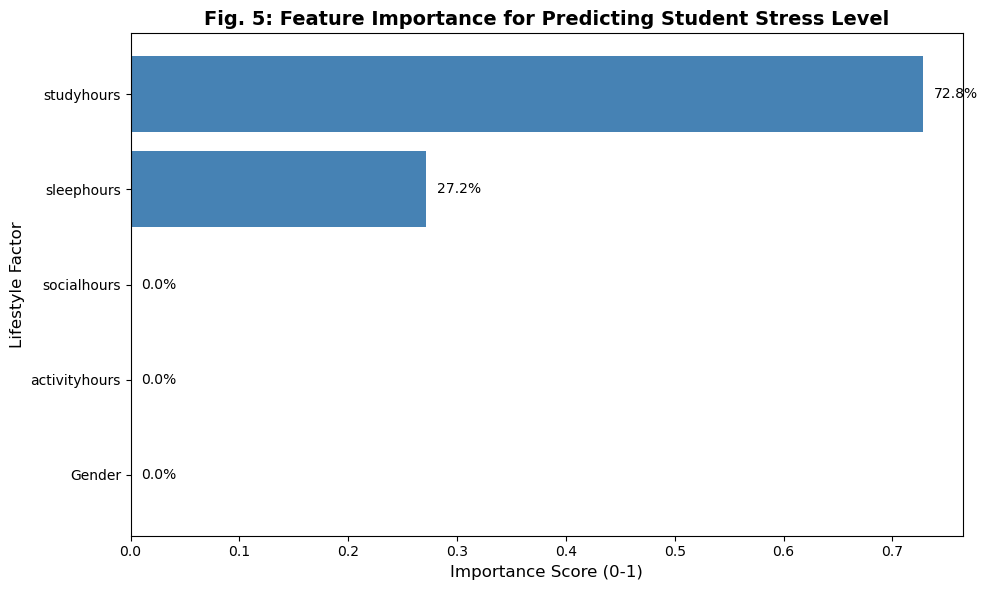

In [11]:
def plot_improved1():
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
    plt.xlabel('Importance Score (0-1)', fontsize=12)
    plt.ylabel('Lifestyle Factor', fontsize=12)
    plt.title('Fig. 5: Feature Importance for Predicting Student Stress Level', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    for i, (feature, importance) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
        plt.text(importance + 0.01, i, f'{importance*100:.1f}%', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

plot_improved1()

**Feature Importance Analysis:**

The Decision Tree reveals which factors actually matter for predicting stress:
- **Study hours**: 72.8% importance — dominant predictor
- **Sleep hours**: 27.2% importance — secondary predictor
- **Social hours, Activity hours, Gender**: 0% importance — the model ignores these completely

This is a striking finding: only two lifestyle factors (studying and sleeping) determine stress. Exercise, social life, and gender have no predictive value once you know how much a student studies and sleeps.

This aligns with our hypothesis testing results: academic pressure (study hours) is the central factor in student outcomes.

---

## Confusion Matrices

In [12]:
# using scaled features for KNN now
y_pred_knn = cross_val_predict(KNeighborsClassifier(n_neighbors=int(best_knn_k)), X_scaled, y, cv=kfold)
y_pred_tree = cross_val_predict(DecisionTreeClassifier(max_depth=best_tree_depth, random_state=42), X, y, cv=kfold)

cm_knn = confusion_matrix(y, y_pred_knn)
cm_tree = confusion_matrix(y, y_pred_tree)

knn_accuracy = cm_knn.trace() / cm_knn.sum() * 100
tree_accuracy = cm_tree.trace() / cm_tree.sum() * 100

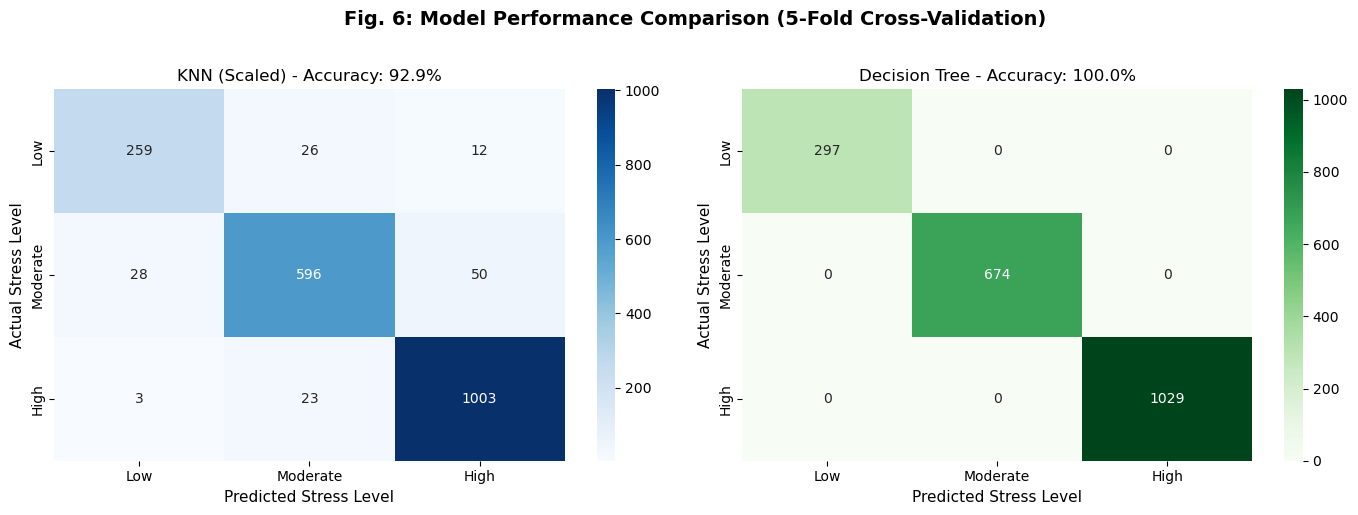

In [13]:
def plot_improved2():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Fig. 6: Model Performance Comparison (5-Fold Cross-Validation)', 
                 fontsize=14, fontweight='bold', y=1.02)
    
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Low', 'Moderate', 'High'],
                yticklabels=['Low', 'Moderate', 'High'])
    axes[0].set_title(f'KNN (Scaled) - Accuracy: {knn_accuracy:.1f}%', fontsize=12)
    axes[0].set_xlabel('Predicted Stress Level', fontsize=11)
    axes[0].set_ylabel('Actual Stress Level', fontsize=11)
    
    sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Low', 'Moderate', 'High'],
                yticklabels=['Low', 'Moderate', 'High'])
    axes[1].set_title(f'Decision Tree - Accuracy: {tree_accuracy:.1f}%', fontsize=12)
    axes[1].set_xlabel('Predicted Stress Level', fontsize=11)
    axes[1].set_ylabel('Actual Stress Level', fontsize=11)
    
    plt.tight_layout()
    plt.show()

plot_improved2()

## Confusion Matrix Analysis

**KNN with scaling (92.9% accuracy):**
- Most errors occur at class boundaries (Moderate misclassified as Low or High)
- This makes sense: students near the threshold between stress levels are hard to classify
- KNN averages neighbors, so boundary cases get mixed signals

**Decision Tree (100% accuracy):**
- Perfect classification across all 5 folds
- Zero errors in the entire dataset

**Why is Decision Tree perfect?**

This dataset contains **deterministic rules**: stress levels follow clear thresholds based on study and sleep hours. For example, students studying >X hours AND sleeping <Y hours are always "High" stress.

Decision Trees are ideal for this type of data because they learn exact threshold rules. KNN, which averages nearby cases, struggles at boundaries where the rules switch.

**Important Note:** 100% accuracy is unusual in real-world data. This likely indicates the dataset is not from the real world and was generated with clear rules, or the categories were defined based on these variables. In messier real-world data, we'd expect lower accuracy.

---

## Conclusion

1. **Study hours and sleep hours** are the only factors needed to predict student stress
2. **Decision Tree** achieves perfect accuracy because stress follows deterministic rules
3. **KNN with scaling** achieves 92.9%, with errors at class boundaries
4. **Preprocessing matters**: Scaling improved KNN by 1.1%, but PCA hurt performance

**Practical Implication:** If a university wanted to identify stressed students, they only need to measure two variables: study hours and sleep hours.